In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import SGD, Adam

from tqdm import tqdm

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

sns.set_palette('muted',color_codes=True)
vc_color = '#B5C9EB'

Using TensorFlow backend.


In [2]:
IM_WIDTH, IM_HEIGHT = 299, 299 
NB_EPOCHS = 25
BATCH_SIZE = 32
FC_SIZE = 1024

TRAIN_DIR = "./data/color/train/"
VAL_DIR = "./data/color/validation/"
EXPORT_DIR = "./saved_models/"

In [3]:
# Get image classes
classes = os.listdir(TRAIN_DIR)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

Number of classes: 38


In [4]:
# Get path and label for each image
db=[]
for label, class_name in enumerate(classes):
    
    # Train
    path = TRAIN_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 1])

    # Validation
    path = VAL_DIR + class_name
    for file in os.listdir(path):
        db.append(['{}/{}'.format(class_name, file), label, class_name, 0])

db = pd.DataFrame(db, columns=['file', 'label', 'class_name', 'train_ind'])

num_train_samples = db.train_ind.sum()
num_val_samples = len(db) - num_train_samples

print(f"Number of train images: {num_train_samples}")
print(f"Number of validation images: {num_val_samples}")

Number of train images: 38089
Number of validation images: 16216


In [5]:
# Specify data generator inputs
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [6]:
# Create data generators
train_generator = train_datagen.flow_from_directory(
  TRAIN_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
)
validation_generator = test_datagen.flow_from_directory(
  VAL_DIR,
  target_size=(IM_WIDTH, IM_HEIGHT),
  batch_size=BATCH_SIZE,
)

Found 38089 images belonging to 38 classes.
Found 16216 images belonging to 38 classes.


In [7]:
# Get Inception model without final layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add new fully connected layer to base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(FC_SIZE, activation='relu')(x) 
predictions = Dense(num_classes, activation='softmax')(x) 
model = Model(input=base_model.input, output=predictions)

In [8]:
# Compile model
model.compile(optimizer=Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set up callbacks
filepath = EXPORT_DIR + "tl_model_weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             mode='max',
                             verbose=1, 
                             save_best_only=True)    

reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                              factor=0.2, 
                              patience=5, 
                              cooldown=5)

csv_logger = CSVLogger('training.log')
callbacks_list = [checkpoint, reduce_lr, csv_logger]

In [9]:
# Fit transfer learning model
history = model.fit_generator(
                train_generator,
                epochs = NB_EPOCHS,
                steps_per_epoch = num_train_samples / BATCH_SIZE,
                validation_data = validation_generator,
                validation_steps = num_val_samples / BATCH_SIZE,
                callbacks = callbacks_list)

Epoch 1/25
1191/1190 [==============================] - 1798s 2s/step - loss: 0.5470 - acc: 0.8358 - val_loss: 0.5549 - val_acc: 0.8564

Epoch 00001: val_acc improved from -inf to 0.85638, saving model to ./saved_models/tl_model_weights_best.hdf5
Epoch 2/25
1191/1190 [==============================] - 1782s 1s/step - loss: 0.2090 - acc: 0.9340 - val_loss: 0.3545 - val_acc: 0.8952

Epoch 00002: val_acc improved from 0.85638 to 0.89523, saving model to ./saved_models/tl_model_weights_best.hdf5
Epoch 3/25
1191/1190 [==============================] - 1782s 1s/step - loss: 0.1554 - acc: 0.9504 - val_loss: 1.0756 - val_acc: 0.7627

Epoch 00003: val_acc did not improve
Epoch 4/25
1191/1190 [==============================] - 1782s 1s/step - loss: 0.1318 - acc: 0.9573 - val_loss: 0.4190 - val_acc: 0.9085

Epoch 00004: val_acc improved from 0.89523 to 0.90849, saving model to ./saved_models/tl_model_weights_best.hdf5
Epoch 5/25
1191/1190 [==============================] - 1781s 1s/step - loss: 0

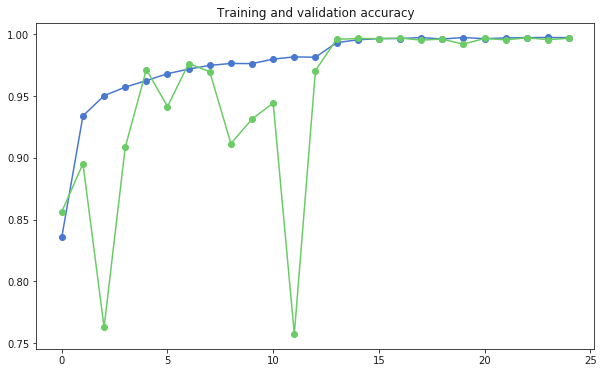

In [13]:
# Plot model accuracy by epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10,6))
plt.plot(epochs, acc, 'o-')
plt.plot(epochs, val_acc, 'o-')
plt.title('Training and validation accuracy')
plt.show()

In [15]:
loss, acc = model.evaluate_generator(validation_generator)
print(f"Validation accuracy: {acc}")

Validation accuracy: 0.9967932905478023
